In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla

def gpr_predict(xB, yB, xPred=None, plot=True):
    # Função objetivo: log-verossimilhança negativa
    def objective(x):
        mxB = x[0]*xB**2 + x[1]*xB + x[2] + x[6]*xB**3 + x[7]*xB**4
        KB = np.zeros((len(xB), len(xB)))
        for i in range(len(xB)):
            for j in range(i, len(xB)):
                noise = x[5]**2 if i == j else 0
                k = x[3]**2 * np.exp(-((xB[i] - xB[j])**2) / (2.0 * x[4]**2)) + noise**2
                KB[i, j] = k
                KB[j, i] = k
        KBinv = np.linalg.inv(KB)
        return -1 * (-0.5 * np.log(np.linalg.det(KB)) - 0.5 * (yB - mxB).T @ KBinv @ (yB - mxB) - len(xB)/2 * np.log(2*np.pi))

    # Restrições nos hiperparâmetros
    cons = [
        lambda x: x[4] - 1,       # ell > 1
        lambda x: 5 - x[4],       # ell < 5
        lambda x: x[3] - 0.8      # sigmaF2 > 0.8
    ]

    # Valores iniciais
    x0 = (0.1, 0.01, 0.01, 2.0, 1.0, 0.01, 0.01, 0.01)
    xopt = fmin_cobyla(objective, x0, cons, disp=0)

    # Hiperparâmetros aprendidos
    c4, c3, c2, c1, c0 = xopt[7], xopt[6], xopt[0], xopt[1], xopt[2]
    ell, sigmaF2, sigmaN2 = xopt[4], xopt[3], xopt[5]

    # Função de média e covariância
    def priormean(xin): return c4*xin**4 + c3*xin**3 + c2*xin**2 + c1*xin + c0
    def corrFunc(xa, xb): return sigmaF2**2 * np.exp(-((xa - xb)**2) / (2.0 * ell**2))

    mxB = priormean(xB)
    KB = np.zeros((len(xB), len(xB)))
    for i in range(len(xB)):
        for j in range(i, len(xB)):
            noise = sigmaN2**2 if i == j else 0
            k = corrFunc(xB[i], xB[j]) + noise**2
            KB[i, j] = k
            KB[j, i] = k
    KBinv = np.linalg.inv(KB)

    if xPred is None:
        xPred = np.arange(0, 10, 0.2)
    Ks = np.array([[corrFunc(xp, xb) for xb in xB] for xp in xPred])
    mus = priormean(xPred)
    ypred = mus + Ks @ KBinv @ (yB - mxB)
    Kss = np.array([[corrFunc(xPred[i], xPred[j]) + (sigmaN2 if i == j else 0) for j in range(len(xPred))] for i in range(len(xPred))])
    yvar = np.diag(Kss - Ks @ KBinv @ Ks.T)
    stds = np.sqrt(yvar)

    if plot:
        x = np.arange(0, 10, 0.1)
        mx = priormean(x)
        plt.figure(figsize=(12, 8))
        plt.plot(x, mx, label="mean $m(x)$")
        plt.plot(xB, yB, 'or', label="training data")
        plt.plot(xPred, ypred, '--g', label="predictions")
        plt.fill_between(xPred, ypred - 2*stds, ypred + 2*stds, color='gray', alpha=0.3, label="95% CI")
        plt.title("Gaussian Process Prediction with Bi-quadratic Mean")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.grid(True)
        plt.show()

    return xPred, ypred, stds

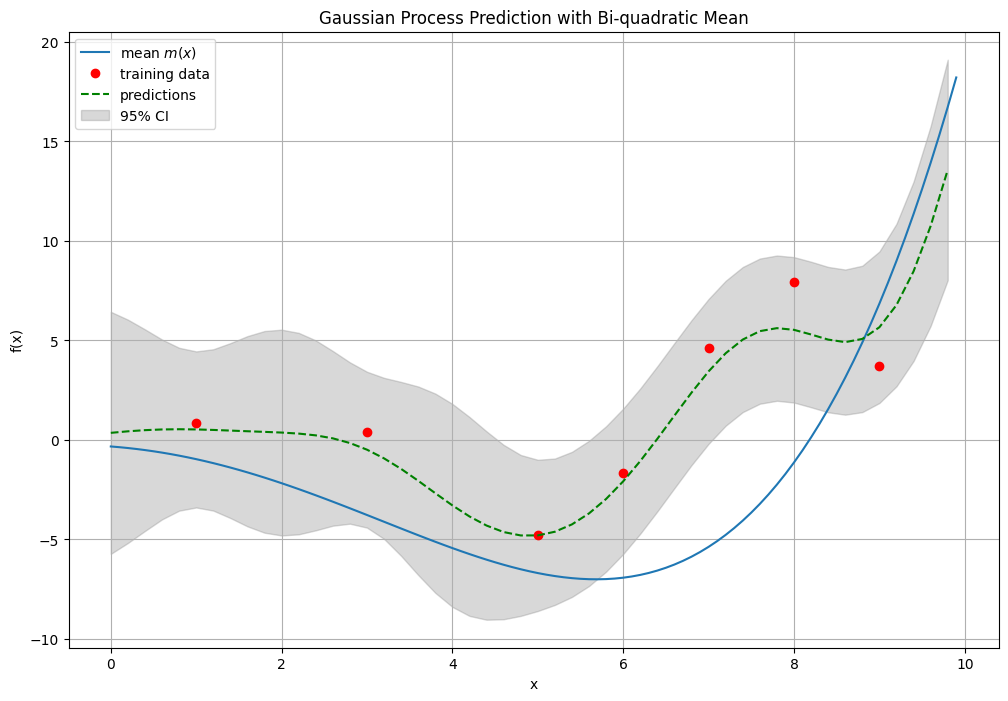

In [28]:
xB = np.array([1., 3., 5., 6., 7., 8., 9.])
yB = xB * np.sin(xB)

xPred, yPred, stds = gpr_predict(xB, yB)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla

def gpr_predict_multidim(XB, yB, XPred=None, plot=True):
    XB = np.atleast_2d(XB)
    n_samples, n_features = XB.shape

    # Função de média prior: linear + constante
    def priormean(Xin, w, b):
        return Xin @ w + b

    # Kernel RBF (Squared Exponential) isotrópico
    def corrFunc(xa, xb, sigmaF2, ell):
        return sigmaF2**2 * np.exp(-np.sum((xa - xb)**2) / (2.0 * ell**2))

    # Função de log-verossimilhança negativa
    def objective(x):
        w = x[:n_features]
        b = x[n_features]
        sigmaF2 = x[n_features + 1]
        ell = x[n_features + 2]
        sigmaN2 = x[n_features + 3]
        mxB = priormean(XB, w, b)
        KB = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i, n_samples):
                noise = sigmaN2**2 if i == j else 0
                k = corrFunc(XB[i], XB[j], sigmaF2, ell) + noise**2
                KB[i, j] = k
                KB[j, i] = k
        KBinv = np.linalg.inv(KB)
        return -1 * (-0.5 * np.log(np.linalg.det(KB)) - 
                     0.5 * (yB - mxB).T @ KBinv @ (yB - mxB) - 
                     n_samples/2 * np.log(2*np.pi))

    # Restrições nos hiperparâmetros
    cons = [
        lambda x: x[n_features + 2] - 1,     # ell > 1
        lambda x: 5 - x[n_features + 2],     # ell < 5
        lambda x: x[n_features + 1] - 0.8    # sigmaF2 > 0.8
    ]

    # Valores iniciais
    x0 = np.ones(n_features + 4) * 0.1
    x0[n_features + 1] = 2.0  # sigmaF2
    x0[n_features + 2] = 1.0  # ell
    x0[n_features + 3] = 0.01 # sigmaN2

    # Otimização
    xopt = fmin_cobyla(objective, x0, cons, disp=0)

    # Hiperparâmetros otimizados
    w = xopt[:n_features]
    b = xopt[n_features]
    sigmaF2 = xopt[n_features + 1]
    ell = xopt[n_features + 2]
    sigmaN2 = xopt[n_features + 3]

    # Matriz de covariância de treino
    mxB = priormean(XB, w, b)
    KB = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):
            noise = sigmaN2**2 if i == j else 0
            k = corrFunc(XB[i], XB[j], sigmaF2, ell) + noise**2
            KB[i, j] = k
            KB[j, i] = k
    KBinv = np.linalg.inv(KB)

    # Pontos de predição padrão (malha 2D se não for fornecido)
    if XPred is None:
        x1 = np.linspace(0, 10, 50)
        x2 = np.linspace(0, 10, 50)
        X1, X2 = np.meshgrid(x1, x2)
        XPred = np.column_stack([X1.ravel(), X2.ravel()])
    else:
        XPred = np.atleast_2d(XPred)

    # Covariância cruzada
    Ks = np.array([[corrFunc(xp, xb, sigmaF2, ell) for xb in XB] for xp in XPred])
    mus = priormean(XPred, w, b)

    # Predição
    ypred = mus + Ks @ KBinv @ (yB - mxB)

    # Variância da predição
    Kss = np.array([
        [corrFunc(XPred[i], XPred[j], sigmaF2, ell) + (sigmaN2 if i == j else 0)
         for j in range(len(XPred))] for i in range(len(XPred))
    ])
    yvar = np.diag(Kss - Ks @ KBinv @ Ks.T)
    stds = np.sqrt(np.maximum(yvar, 0))

    # Visualização (apenas se 2D)
    if plot and n_features == 2:
        x1 = XPred[:, 0].reshape(50, 50)
        x2 = XPred[:, 1].reshape(50, 50)
        ypred_grid = ypred.reshape(50, 50)
        plt.figure(figsize=(10, 8))
        plt.contourf(x1, x2, ypred_grid, cmap='viridis')
        plt.colorbar(label='Prediction')
        plt.scatter(XB[:, 0], XB[:, 1], c=yB, edgecolors='k', cmap='viridis', label="Training")
        plt.title("Gaussian Process Regression (2D)")
        plt.xlabel("x₁")
        plt.ylabel("x₂")
        plt.legend()
        plt.show()

    return XPred, ypred, stds


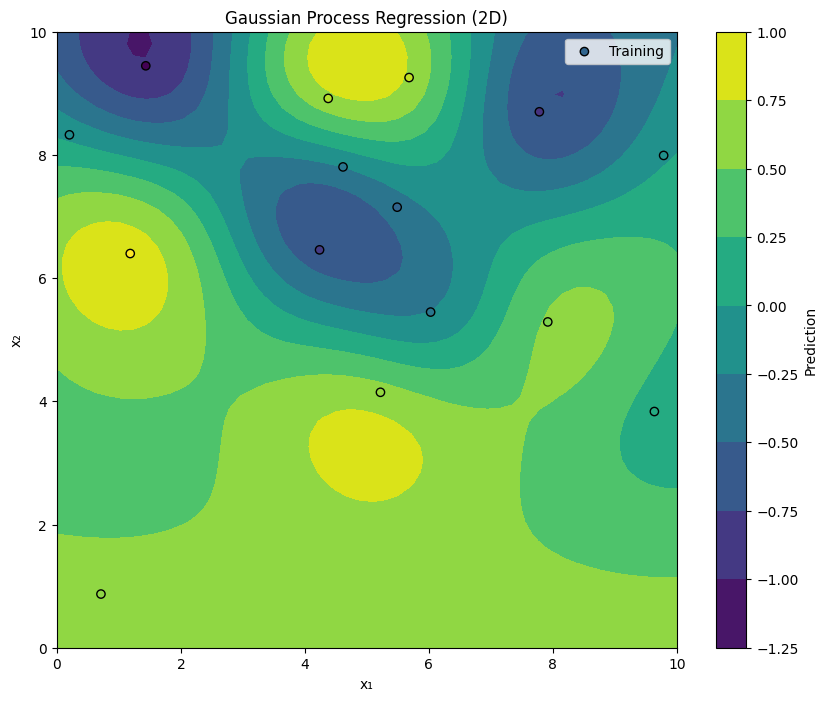

In [32]:
import numpy as np

# Cria dados de treino 2D: 15 pontos aleatórios no intervalo [0, 10]
np.random.seed(0)
XB = np.random.uniform(0, 10, (15, 2))

# Função alvo: sin(x1) * cos(x2) + ruído
yB = np.sin(XB[:, 0]) * np.cos(XB[:, 1])  + 0.1 * np.random.randn(15)
XPred, ypred, stds = gpr_predict_multidim(XB, yB, plot=True)